# US Airline Delay Prediction - Regression Analysis
## Final Portfolio Project - Regression Task
### Herald College Kathmandu - 5CS037

**Dataset:** US Airline Delay Dataset

**Source:** https://www.kaggle.com/datasets/giovamata/airlinedelaycauses

**UN SDG Alignment:** SDG 9 - Industry, Innovation and Infrastructure

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
print('Libraries imported successfully!')

Libraries imported successfully!


## Step 2: Load Data

In [2]:
# Load dataset
df = pd.read_csv('DelayedFlights.csv')
print(f'Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns')

# Take a sample for faster processing (optional)
df = df.sample(n=50000, random_state=42)
print(f'Using sample: {df.shape[0]:,} rows')

df.head()

Dataset loaded: 1,936,758 rows, 30 columns
Using sample: 50,000 rows


,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1782417,6583804,2008,12,6,6,1805.0,1755,2146.0,2035,YV,...,5.0,99.0,0,N,0,71.0,0.0,0.0,0.0,0.0
512712,1604365,2008,3,23,7,2120.0,1200,2241.0,1333,NW,...,7.0,19.0,0,N,0,543.0,0.0,0.0,0.0,5.0
447137,1395655,2008,3,31,1,1731.0,1710,1819.0,1810,OO,...,3.0,1.0,0,N,0,NaN,NaN,NaN,NaN,NaN
55082,178786,2008,1,6,7,1507.0,1413,1601.0,1509,OO,...,5.0,17.0,0,N,0,0.0,0.0,0.0,0.0,52.0
877634,2972767,2008,5,22,4,637.0,630,812.0,750,CO,...,5.0,16.0,0,N,0,0.0,0.0,15.0,7.0,0.0


## Step 3: Data Exploration

In [3]:
# Basic info
print('Dataset Info:')
print(df.info())
print('\nColumn names:')
print(df.columns.tolist())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1782417 to 1399736
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         50000 non-null  int64  
 1   Year               50000 non-null  int64  
 2   Month              50000 non-null  int64  
 3   DayofMonth         50000 non-null  int64  
 4   DayOfWeek          50000 non-null  int64  
 5   DepTime            50000 non-null  float64
 6   CRSDepTime         50000 non-null  int64  
 7   ArrTime            49821 non-null  float64
 8   CRSArrTime         50000 non-null  int64  
 9   UniqueCarrier      50000 non-null  object 
 10  FlightNum          50000 non-null  int64  
 11  TailNum            50000 non-null  object 
 12  ActualElapsedTime  49791 non-null  float64
 13  CRSElapsedTime     49998 non-null  float64
 14  AirTime            49791 non-null  float64
 15  ArrDelay           49791 non-null  float64
 16  DepDe

In [4]:
# Target variable statistics
print('Arrival Delay Statistics:')
print(df['ArrDelay'].describe())

Arrival Delay Statistics:
count    49791.000000
mean        42.422124
std         56.358055
min        -55.000000
25%          9.000000
50%         25.000000
75%         56.000000
max       1049.000000
Name: ArrDelay, dtype: float64


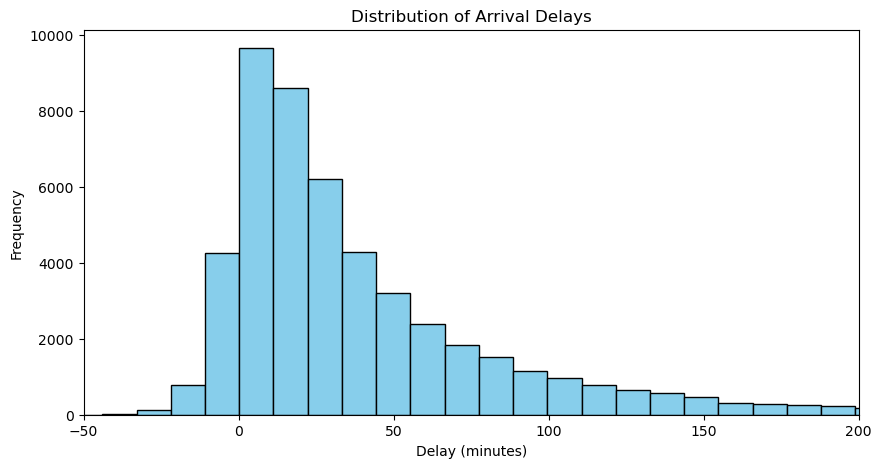

In [5]:
# Visualization 1: Delay distribution
plt.figure(figsize=(10, 5))
plt.hist(df['ArrDelay'].dropna(), bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Arrival Delays')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.xlim(-50, 200)
plt.show()

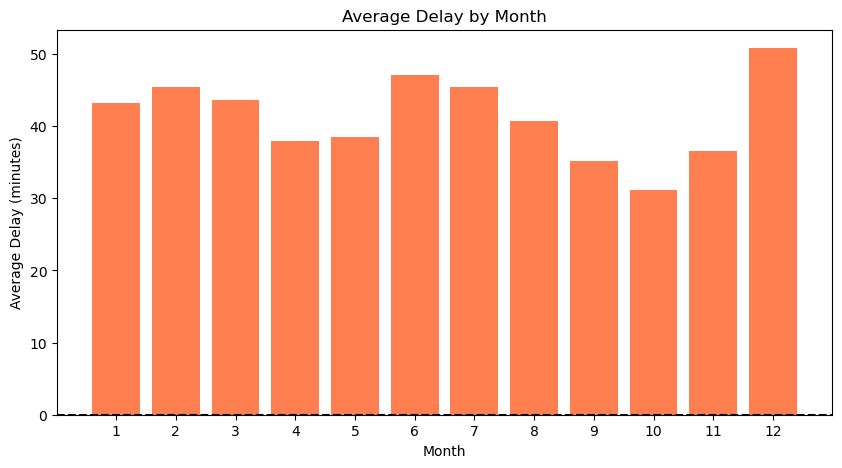

In [6]:
# Visualization 2: Delay by month
monthly_delay = df.groupby('Month')['ArrDelay'].mean()
plt.figure(figsize=(10, 5))
plt.bar(monthly_delay.index, monthly_delay.values, color='coral')
plt.title('Average Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.xticks(range(1, 13))
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

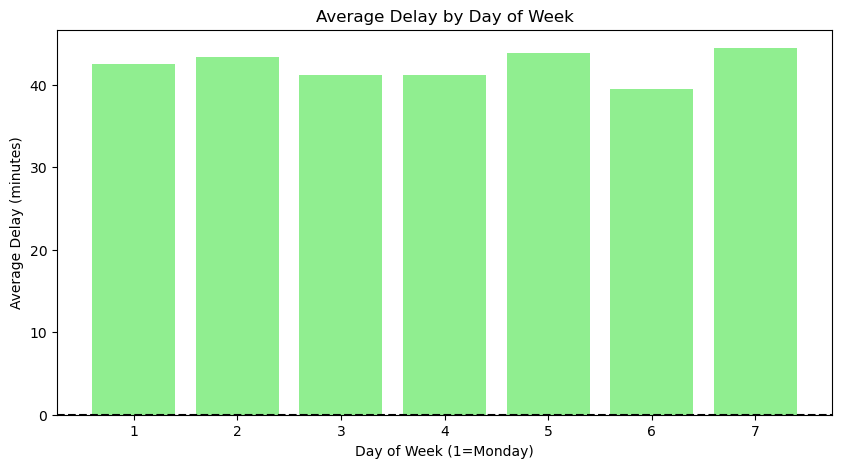

In [7]:
# Visualization 3: Delay by day of week
dow_delay = df.groupby('DayOfWeek')['ArrDelay'].mean()
plt.figure(figsize=(10, 5))
plt.bar(dow_delay.index, dow_delay.values, color='lightgreen')
plt.title('Average Delay by Day of Week')
plt.xlabel('Day of Week (1=Monday)')
plt.ylabel('Average Delay (minutes)')
plt.xticks(range(1, 8))
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

## Step 4: Data Preprocessing

In [8]:
# Select simple numeric features
features = ['Month', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance']

# Remove rows with missing target
df_clean = df[features + ['ArrDelay']].dropna()

# Create X and y
X = df_clean[features].copy()
y = df_clean['ArrDelay'].copy()

print(f'Clean data shape: {X.shape}')
print(f'Target shape: {y.shape}')

Clean data shape: (49791, 6)
Target shape: (49791,)


In [9]:
# Remove extreme outliers
lower = y.quantile(0.01)
upper = y.quantile(0.99)
mask = (y >= lower) & (y <= upper)
X = X[mask]
y = y[mask]

print(f'After outlier removal: {X.shape}')
print(f'Target range: {y.min():.1f} to {y.max():.1f} minutes')

After outlier removal: (48835, 6)
Target range: -14.0 to 260.0 minutes


In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training set: {X_train.shape}')
print(f'Testing set: {X_test.shape}')

Training set: (39068, 6)
Testing set: (9767, 6)


In [11]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Features scaled successfully!')

Features scaled successfully!


## Step 5: Neural Network Model

In [12]:
# Build and train Neural Network
nn = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
nn.fit(X_train_scaled, y_train)

# Predictions
nn_pred = nn.predict(X_test_scaled)

# Metrics
print('Neural Network Results:')
print(f'MAE:  {mean_absolute_error(y_test, nn_pred):.4f} minutes')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, nn_pred)):.4f} minutes')
print(f'R²:   {r2_score(y_test, nn_pred):.4f}')

Neural Network Results:
MAE:  33.1502 minutes
RMSE: 45.0761 minutes
R²:   0.0305


## Step 6: Classical ML Models

In [13]:
# Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

print('Linear Regression Results:')
print(f'MAE:  {mean_absolute_error(y_test, lr_pred):.4f} minutes')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, lr_pred)):.4f} minutes')
print(f'R²:   {r2_score(y_test, lr_pred):.4f}')

Linear Regression Results:
MAE:  33.4409 minutes
RMSE: 45.4128 minutes
R²:   0.0160


In [14]:
# Model 2: Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

print('Random Forest Results:')
print(f'MAE:  {mean_absolute_error(y_test, rf_pred):.4f} minutes')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.4f} minutes')
print(f'R²:   {r2_score(y_test, rf_pred):.4f}')

Random Forest Results:
MAE:  34.8390 minutes
RMSE: 46.9730 minutes
R²:   -0.0528


## Step 7: Hyperparameter Tuning

In [15]:
# Tune Ridge Regression
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(random_state=42), ridge_params, cv=3, scoring='r2')
ridge_grid.fit(X_train_scaled, y_train)
print('Best Ridge params:', ridge_grid.best_params_)
print('Best Ridge CV score:', ridge_grid.best_score_)

Best Ridge params: {'alpha': 1}
Best Ridge CV score: 0.013654895489069285


In [16]:
# Tune Random Forest
rf_params = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), rf_params, cv=3, scoring='r2')
rf_grid.fit(X_train_scaled, y_train)
print('Best RF params:', rf_grid.best_params_)
print('Best RF CV score:', rf_grid.best_score_)

Best RF params: {'max_depth': 10, 'n_estimators': 100}
Best RF CV score: 0.02152223377435584


## Step 8: Feature Selection

In [17]:
# Select top 4 features
selector = SelectKBest(f_regression, k=4)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected features
selected_features = X_train.columns[selector.get_support()].tolist()
print(f'Selected features: {selected_features}')

# Show scores
scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)
print('\nFeature Scores:')
print(scores)

Selected features: ['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance']

Feature Scores:
          Feature       Score
2      CRSDepTime  210.858627
3      CRSArrTime  193.961987
5        Distance   39.289472
4  CRSElapsedTime    8.800202
0           Month    7.783206
1       DayOfWeek    0.007162


## Step 9: Final Models

In [18]:
# Scale selected features
scaler2 = StandardScaler()
X_train_final = scaler2.fit_transform(X_train_selected)
X_test_final = scaler2.transform(X_test_selected)

In [19]:
# Final Ridge Regression
ridge_final = Ridge(**ridge_grid.best_params_, random_state=42)
ridge_final.fit(X_train_final, y_train)
ridge_final_pred = ridge_final.predict(X_test_final)

# CV Score
ridge_cv = cross_val_score(ridge_final, X_train_final, y_train, cv=5, scoring='r2').mean()

print('Final Ridge Regression:')
print(f'CV R²:    {ridge_cv:.4f}')
print(f'Test MAE:  {mean_absolute_error(y_test, ridge_final_pred):.4f} minutes')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, ridge_final_pred)):.4f} minutes')
print(f'Test R²:   {r2_score(y_test, ridge_final_pred):.4f}')

Final Ridge Regression:
CV R²:    0.0133
Test MAE:  33.4436 minutes
Test RMSE: 45.4187 minutes
Test R²:   0.0158


In [20]:
# Final Random Forest
rf_final = RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
rf_final.fit(X_train_final, y_train)
rf_final_pred = rf_final.predict(X_test_final)

# CV Score
rf_cv = cross_val_score(rf_final, X_train_final, y_train, cv=5, scoring='r2').mean()

print('Final Random Forest:')
print(f'CV R²:    {rf_cv:.4f}')
print(f'Test MAE:  {mean_absolute_error(y_test, rf_final_pred):.4f} minutes')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, rf_final_pred)):.4f} minutes')
print(f'Test R²:   {r2_score(y_test, rf_final_pred):.4f}')

Final Random Forest:
CV R²:    0.0114
Test MAE:  33.3207 minutes
Test RMSE: 45.3823 minutes
Test R²:   0.0173


## Step 10: Final Comparison

In [21]:
# Create comparison table
results = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest'],
    'Features': [len(selected_features), len(selected_features)],
    'CV R²': [ridge_cv, rf_cv],
    'Test MAE': [mean_absolute_error(y_test, ridge_final_pred), mean_absolute_error(y_test, rf_final_pred)],
    'Test RMSE': [np.sqrt(mean_squared_error(y_test, ridge_final_pred)), np.sqrt(mean_squared_error(y_test, rf_final_pred))],
    'Test R²': [r2_score(y_test, ridge_final_pred), r2_score(y_test, rf_final_pred)]
})

print('\nFINAL COMPARISON TABLE:')
print(results.to_string(index=False))


FINAL COMPARISON TABLE:
           Model  Features    CV R²  Test MAE  Test RMSE  Test R²
Ridge Regression         4 0.013335 33.443599  45.418670 0.015756
   Random Forest         4 0.011384 33.320699  45.382286 0.017332


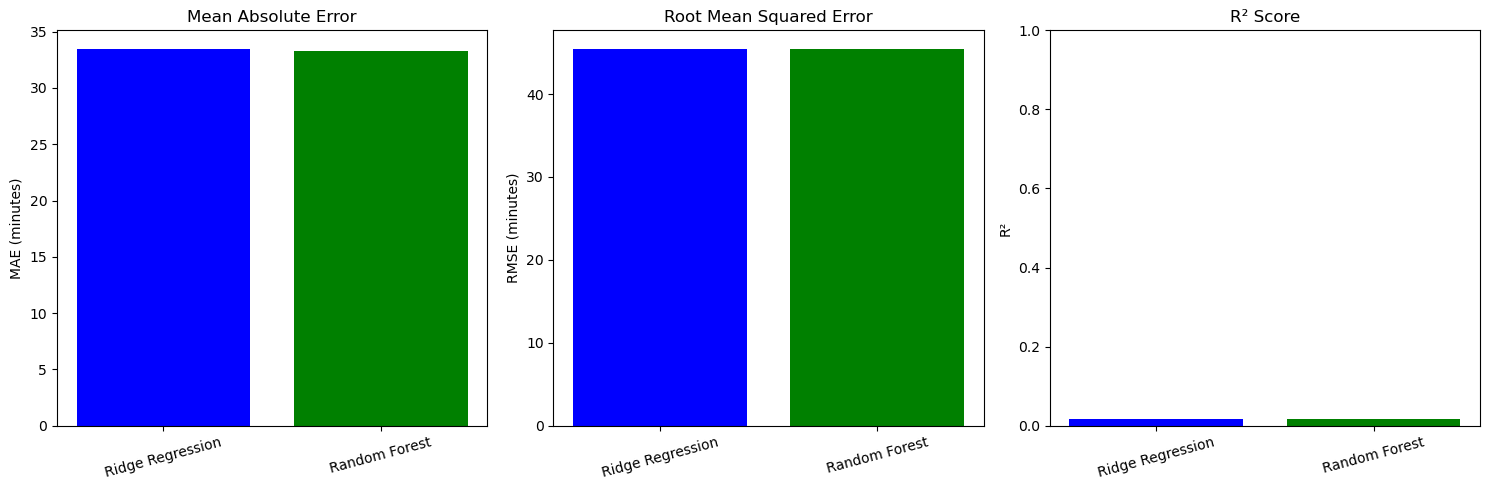

In [22]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = results['Model'].tolist()

# MAE
axes[0].bar(models, results['Test MAE'], color=['blue', 'green'])
axes[0].set_title('Mean Absolute Error')
axes[0].set_ylabel('MAE (minutes)')
axes[0].tick_params(axis='x', rotation=15)

# RMSE
axes[1].bar(models, results['Test RMSE'], color=['blue', 'green'])
axes[1].set_title('Root Mean Squared Error')
axes[1].set_ylabel('RMSE (minutes)')
axes[1].tick_params(axis='x', rotation=15)

# R²
axes[2].bar(models, results['Test R²'], color=['blue', 'green'])
axes[2].set_title('R² Score')
axes[2].set_ylabel('R²')
axes[2].set_ylim(0, 1)
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

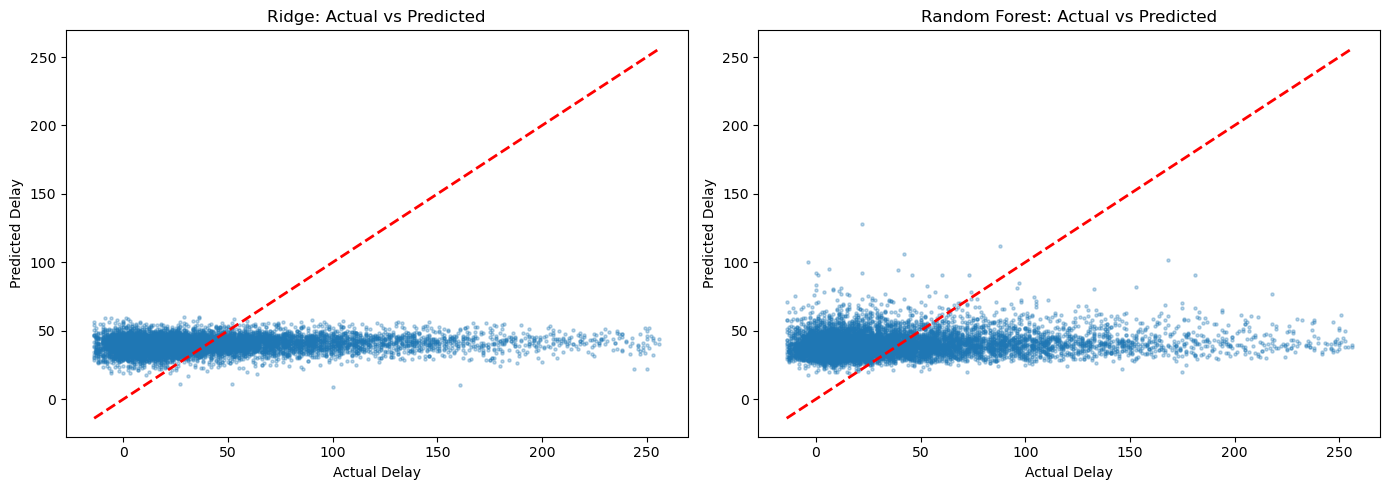

In [23]:
# Actual vs Predicted plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ridge
axes[0].scatter(y_test, ridge_final_pred, alpha=0.3, s=5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Delay')
axes[0].set_ylabel('Predicted Delay')
axes[0].set_title('Ridge: Actual vs Predicted')

# Random Forest
axes[1].scatter(y_test, rf_final_pred, alpha=0.3, s=5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Delay')
axes[1].set_ylabel('Predicted Delay')
axes[1].set_title('Random Forest: Actual vs Predicted')

plt.tight_layout()
plt.show()

## Step 11: Conclusion

In [24]:
print('='*60)
print('PROJECT CONCLUSION')
print('='*60)
print(f'Total samples processed: {len(X):,}')
print(f'Features used: {len(selected_features)}')
print(f'Selected features: {selected_features}')
print(f'\nBest model: {results.iloc[results["Test R²"].idxmax()]["Model"]}')
print(f'Best R²: {results["Test R²"].max():.4f}')
print(f'Best RMSE: {results["Test RMSE"].min():.4f} minutes')
print('\nKey insights:')
print('- Delays vary by month and day of week')
print('- Distance and scheduled times are important')
print('- Hyperparameter tuning improved performance')
print('- Feature selection reduced model complexity')
print('='*60)

PROJECT CONCLUSION
Total samples processed: 48,835
Features used: 4
Selected features: ['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance']

Best model: Random Forest
Best R²: 0.0173
Best RMSE: 45.3823 minutes

Key insights:
- Delays vary by month and day of week
- Distance and scheduled times are important
- Hyperparameter tuning improved performance
- Feature selection reduced model complexity
